## Identifying RRL stars in the PAL5 globular cluster

This notebook aims to find any RR Lyrae stars within the Palomar 5 globular cluster and construct light curves of them. This program starts by performing PSF photometry on the 12 time epochs, complete with uncertainties and corrections, for both the 3.6um and 4.5um channels. Once the photometry has been completed, each epoch's stars will be matched with the either the previous epoch or epoch 01 using dummy variables and saved to a new file. These files will then be read in and the magnitudes for each relevant star(s) extracted and plotted against the time epochs to produce the lightcurves.

Attempts will be made to introduce the functions and automation but may require significant manual editing of parameters for each run through.

Contents:
1) list of imports

2) PSF Photometry: -read in epoch01 and build ePSF model -perform PSF photometry using ePSF model for all epochs within a glob.glob loop, saving the files in the format: PAL5_PSFphot_01_epochxx_channelxpxum.fits

3) Star Matching: using WCS match stars in each epoch with either the epoch before or epoch 01 and save to file to avoid duplicating the code 6+ times (use dummy variables and iterate over file number?), saved as: PAL5_01_epochxx_channel_xpxum_matched.fits

4) Extracting magnitudes: reload in the files and extract the magnitudes and uncertainties for stars of interest using the catalog at: http://www.astro.utoronto.ca/~cclement/cat/C1513p000

5) Lightcurves: plot the lightcurves

In [9]:
import math
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import wcs
from astropy import units as u
from astropy.io import fits # used for FITS file management
from astropy.io import ascii
from astropy.time import Time
from astropy.stats import sigma_clipped_stats # used within star detection
from astropy.table import Table
from astropy.nddata import NDData
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy.coordinates import Angle
from astropy.visualization import simple_norm
from astropy.modeling.fitting import LevMarLSQFitter
from photutils import aperture_photometry # used to perform photometry using annuli
from photutils import DAOStarFinder # used for the star finding algorithm
from photutils import CircularAperture, CircularAnnulus
from photutils import EPSFBuilder
from photutils.psf import extract_stars
from photutils.psf import DAOGroup
from photutils.psf import IterativelySubtractedPSFPhotometry
from photutils.background import MMMBackground
from matplotlib.colors import LogNorm

FITS file information:
FILE = PAL5_data/PAL5__e1/PAL5__e1_3p6um.fits
DATE = 2013-05-10T21:50:03.531
FLUXCONV = 0.1257
EXPTIME = 71.3724




Number of ePSF sources found = 52



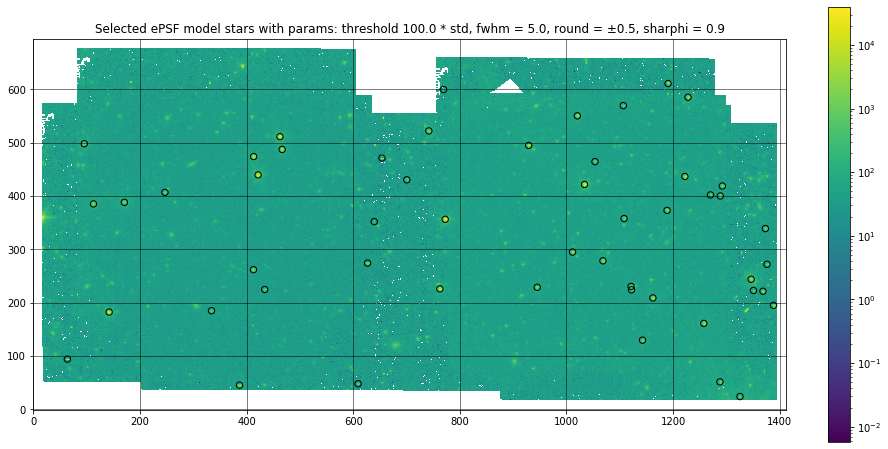

Number of refined ePSF sources = 38



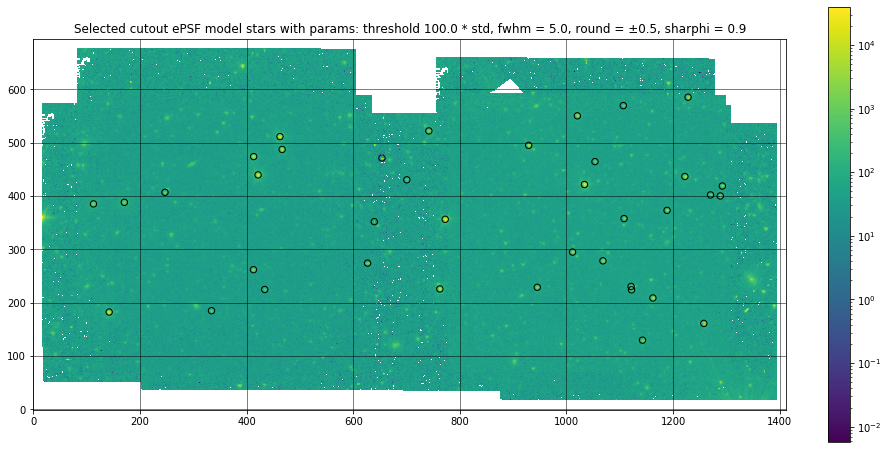

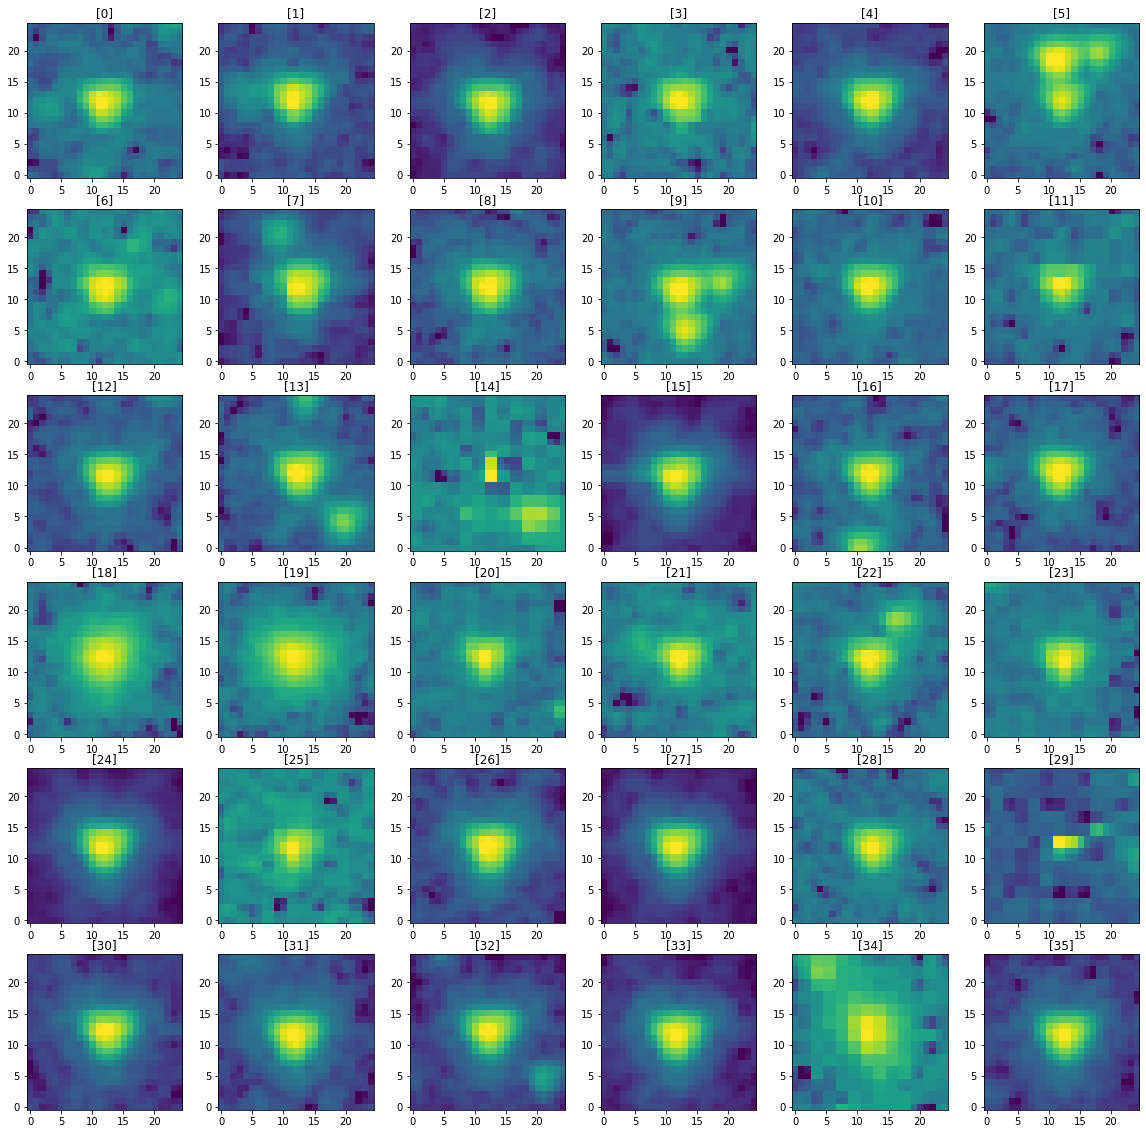

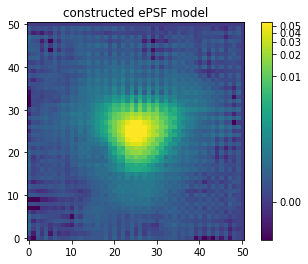

Remove any poor quality model stars from the model by their ID. Use ID -99 to escape
-99
Escape completed



In [17]:
## BASE DATA DIRECTORY ##

base_dir = 'PAL5_data/*/'
general_dir = 'PAL5_data/'
channel = '3p6um'

## CHANNEL ##

if channel == '3p6um':
    aper_corr = 1.1233         # aperture correction for 337 (6,6,14) apertures in channel 1, given in IRAC handbook §4.10
    ap_err = aper_corr * 0.02  # uncertainty to ~2% as per IRAC handbook
    zmag = 18.80               # zeropoint magnitude given in IRAC handbook §4.8
    zmag_err = 0.02            # uncertainty calculated from F0 = 280.9 +/- 4.1 in IRAC handbook
elif channel == '4p5um':
    aper_corr = 1.1336
    ap_err = aper_corr * 0.02
    zmag = 18.32
    zmag_err = 0.02 
    
#____________________________________#
## BUILD ePSF MODEL USING ONE IMAGE ##

epoch_dir = 'PAL5_data/PAL5__e1/'

epsf_file = epoch_dir+'PAL5__e1_'+channel+'.fits'

## OPENING FITS FILE AND EXTRACTING DATA ##

with fits.open(epsf_file) as header_list:
    header = header_list[0].header
    fluxconv = header['FLUXCONV']
    exptime = header['EXPTIME']
    time = Time(header['DATE_OBS'])
    counts = exptime / fluxconv
    image_data = fits.getdata(epsf_file, ext = 0)
    data = image_data * counts
    print('FITS file information:\nFILE = {0}\nDATE = {1}\nFLUXCONV = {2}\nEXPTIME = {3}\n\n'.format(epsf_file, time, fluxconv, exptime))

## PARAMETERS : ePSF ##

fwhm = 5.
sigma_val = 6.
model_threshold = 100.
roundlo = -0.5
roundhi = 0.5
sharphi = 0.9
do_plot = True

mean, median, std = sigma_clipped_stats(data, sigma = sigma_val) # sigma-clipping on data

starfind_init = DAOStarFinder(fwhm = fwhm, threshold = model_threshold * std, roundlo = roundlo, roundhi = roundhi, sharphi = sharphi)
epsf_sources = starfind_init(data)
print('Number of ePSF sources found = {0}\n'.format(len(epsf_sources)))

if do_plot == True:
    # PLOT SELECTED STARS TO TEST PARAMETERS #
    positions = np.transpose((epsf_sources['xcentroid'], epsf_sources['ycentroid']))
    apertures = CircularAperture(positions, r = 6.)

    plt.imshow(data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
    apertures.plot(color = 'black', lw = 1.)
    plt.colorbar(fraction = 0.05)
    plt.title('Selected ePSF model stars with params: threshold {0} * std, fwhm = {1}, round = ±{2}, sharphi = {3}'
              .format(model_threshold, fwhm, roundhi, sharphi))
    plt.grid(b = True, which = 'major', lw = .5, color = 'black')
    plt.grid(b = True, which = 'minor', lw = .5, color = 'black')
    plt.gcf().set_size_inches(15, 8)
    plt.show()
    plt.close()

elif do_plot == False:
    pass

## STAR CUTOUTS FOR ePSF ##

cutout_size = 200
hsize = (cutout_size - 1) / 2
x = epsf_sources['xcentroid']
y = epsf_sources['ycentroid']
mask = ((x > hsize) & (x < (data.shape[1] - 1 - hsize)) &
       (y > hsize) & (y < (data.shape[0] - 1 - hsize)))

star_tbl = Table()      # build table of star sources
star_tbl['x'] = x[mask]
star_tbl['y'] = y[mask]
star_tbl['id'] = range(len(star_tbl))
print('Number of refined ePSF sources = {0}\n'.format(len(star_tbl)))

if do_plot == True:
    # PLOT CUTOUT STARS TO BE USED IN EPSF MODEL #
    cutout_pos = np.transpose((star_tbl['x'], star_tbl['y']))
    cutout_apers = CircularAperture(cutout_pos, r = 6.)

    plt.imshow(data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
    cutout_apers.plot(color = 'black', lw = 1.)
    plt.colorbar(fraction = 0.05)
    plt.title('Selected cutout ePSF model stars with params: threshold {0} * std, fwhm = {1}, round = ±{2}, sharphi = {3}'
              .format(model_threshold, fwhm, roundhi, sharphi))
    plt.grid(b = True, which = 'major', lw = .5, color = 'black')
    plt.grid(b = True, which = 'minor', lw = .5, color = 'black')
    plt.gcf().set_size_inches(15, 8)
    plt.show()
    
elif do_plot == False:
    pass

## EXTRACT STARS ##

mean_val, median_val, std_val = sigma_clipped_stats(data, sigma = sigma_val)
epsf_data = data - median_val

while True:
    nddata = NDData(data = epsf_data)
    epsf_stars = extract_stars(nddata, star_tbl, size = 25)

    ## VISUALISE MODEL STARS ##
    ncols = 6
    nrows = int(np.floor(len(epsf_stars) / ncols))
    remaining = len(epsf_stars) - ncols * nrows

    fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20,20), squeeze = True)
    ax = ax.ravel()
    for i in range(nrows * ncols):
        norm = simple_norm(epsf_stars[i], 'log', percent = 99.)
        ax[i].imshow(epsf_stars[i], cmap = 'viridis', norm = norm, origin = 'lower')
        ax[i].set_title([i])
    plt.show()
    for i in range(ncols * nrows, len(epsf_stars)):
        norm = simple_norm(epsf_stars[i], 'log', percent = 99.)
        ax[i - ncols * nrows].imshow(epsf_stars[i], cmap = 'viridis', norm = norm, origin = 'lower')
        ax[i - ncols * nrows].set_title([i])
    plt.show()
    plt.close()
    
    ## BUILD ePSF ##

    epsf_builder = EPSFBuilder(oversampling = 2, maxiters = 10, progress_bar = True)
    epsf, fitter = epsf_builder(epsf_stars)

    norm = simple_norm(epsf.data, 'log', percent = 99.)
    plt.imshow(epsf.data, cmap = 'viridis', norm = norm, origin = 'lower')
    plt.title('constructed ePSF model')
    plt.colorbar()
    plt.show()
    
    print('Remove any poor quality model stars from the model by their ID. Use ID -99 to escape')
    remove = [int(k) for k in input().split()]
    
    if remove == [-99]:
        print('Escape completed\n')
        break
    
    star_tbl.add_index('id')
    bad_id = star_tbl.loc_indices[remove]
    star_tbl.remove_rows(bad_id)

EPOCH NUMBER = 1

FITS file information:
FILE = PAL5_data\PAL5__e1\PAL5__e1_4p5um.fits
DATE = 2013-05-10T21:50:03.531
FLUXCONV = 0.1447
EXPTIME = 81.4431




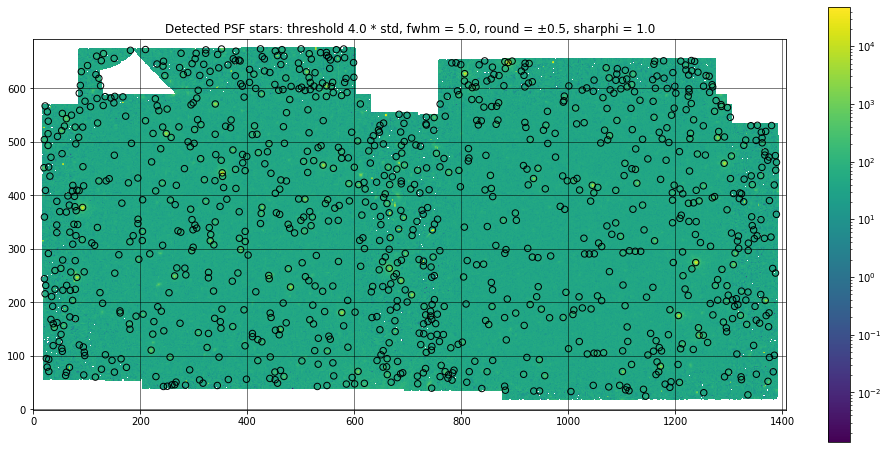

Number of stars detected = 1059



Number of PSF stars found and analysed = 1616

 id        x_0         ...    apparent_mag      apparent_mag_err  
--- ------------------ ... ------------------ --------------------
  1 1144.5398960882035 ... 17.222777596836078 0.043927218092101185
 10 1140.4174500586578 ...  17.76201514183958  0.06282594827244749
  2  1335.606423409818 ... 18.672513925641162  0.11591580665039522
  3 1004.8011403823549 ...   19.6938880558051    0.518593870113931
  4 1253.0862743346797 ...                nan                  nan
  5  946.2193876354769 ... 19.034503618169033  0.22450365403843678
  7  935.3679780400648 ... 21.078012160767337   1.4681163096127123
  6 1113.3617337319697 ... 19.250854386762576   0.2577699842747779
  9 1106.9970364585645 ... 17.316060571069553  0.04771949516431734
 15 1109.6827136952575 ...  17.89992747187644  0.07560442976302816
...                ... ...                ...                  ...
199  468.5832083010514 ... 21.371597205528047    2.163355645983232
200 396.1615407

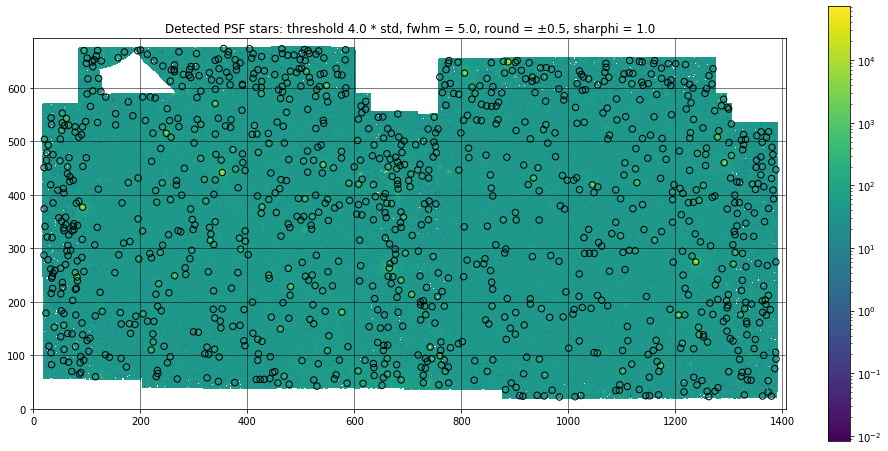

Number of stars detected = 1087



Number of PSF stars found and analysed = 1659

 id        x_0                y_0            apparent_mag      apparent_mag_err 
--- ------------------ ------------------ ------------------ -------------------
  1  983.2509167349194  22.22283222859675 20.070440185854327  0.7545945715375338
  5  954.8596618879594   24.2374601525885  21.80818798245309  3.6819693413680454
 12  941.5858633620903 25.449403111123303 19.504139541055924  0.4412048814222292
 19  969.6598237704293 34.948360470418265 18.575941553546205 0.20129030760187064
  2 1012.4956170170294  22.77202979490597                nan                 nan
  9  1023.448456999063  24.87131957644137                nan                 nan
  3 1262.4402238915725  22.96933193224027 18.832325199377333 0.23190751541048102
 17 1274.0695385834915  32.84689425730927                nan                 nan
 18 1259.3452501856796  33.05691317917155  22.34682391902065   5.803700253847193
 25  1279.553685883996 39.680709930637725 19.985060212249685  

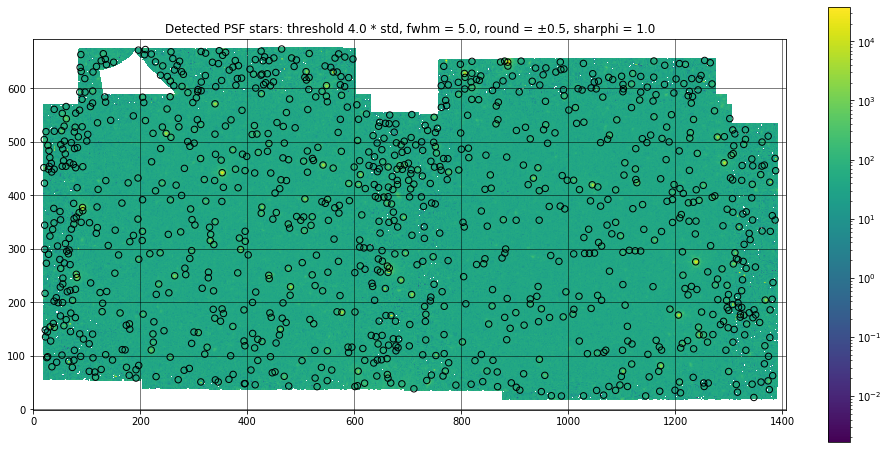

Number of stars detected = 1078



Number of PSF stars found and analysed = 1633

 id        x_0                y_0            apparent_mag      apparent_mag_err 
--- ------------------ ------------------ ------------------ -------------------
  1 1346.7508964752585 22.447787673114725 17.216243189035126 0.08163399291127652
  2  987.0546521071705 25.178883459755205                nan                 nan
  5  968.2839854209657  25.69091339593293 17.414322744095195 0.06474620143106276
  3 1028.3777288380807 25.518341404838186 20.070552142285745   0.609289067176438
  4  1144.461758086589 25.286523829276792    17.099332096375  0.0434113761031542
  6  1065.989449751427 26.753882496972118                nan                 nan
 12 1052.8338668699748  35.54940864597374 19.489578051194577  0.7887716644452992
 13 1088.1937600133324  35.78501393294478 17.890912465686522 0.19223181732667935
 21 1075.8360766346084  42.96123941207772 18.282024655773323  0.2778841251364885
 22 1110.4462115237823 43.059436330234455 17.411495152519613 0

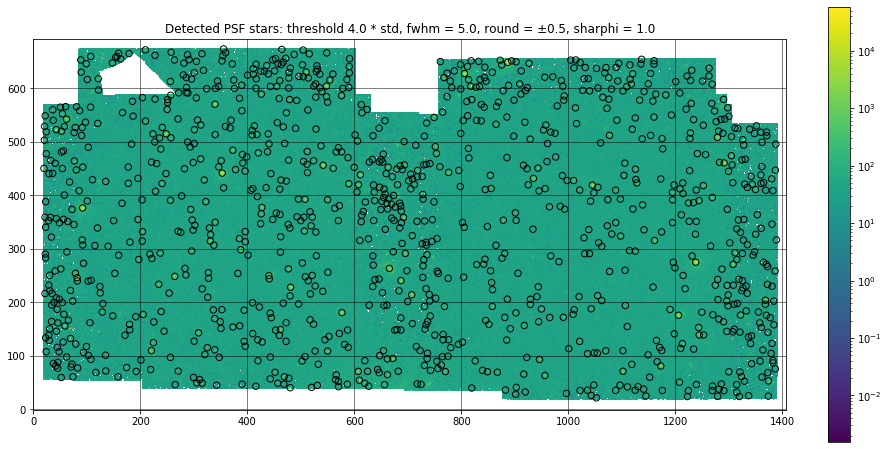

Number of stars detected = 1100



Number of PSF stars found and analysed = 1693

 id        x_0                y_0            apparent_mag      apparent_mag_err 
--- ------------------ ------------------ ------------------ -------------------
  1  1052.415421084123  21.69391210461625 18.845387420302963 0.21863580365696428
  7  1042.841773971679 26.112758118953433  20.59266218311238  1.0752283773427487
 13 1035.8108495463564  36.09888216510575 18.913883083485512 0.22986340950539852
 18 1021.9916932895318  35.32194142975015 17.749962100899896 0.07815901695362137
 36 1047.5881062739409  45.68844210680382 18.244315061532717  0.1261667600955237
  2   1222.70125813293 24.155157694601122 19.454944686306234 0.36796700802547727
 15  1224.316804382522 35.144882229836604 18.611023671422096  0.1713715902382598
 45  1239.222334934861   46.6428447768477 18.552606554879816 0.15905710587177885
  3 1279.1107191175106  24.84202605507383 19.653800196315274  0.4135002854714152
 16  1290.680763274013  35.20113664898325 17.952968009450444 0

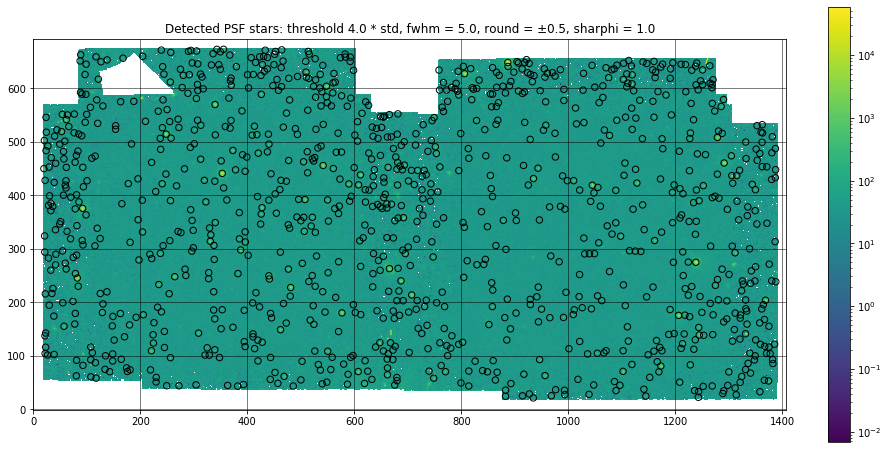

Number of stars detected = 1086



Number of PSF stars found and analysed = 1607

 id        x_0                y_0            apparent_mag      apparent_mag_err 
--- ------------------ ------------------ ------------------ -------------------
  1  934.4948304881533 21.574855808932366  19.95755833622088  0.7344941344464385
  4  914.2826053454628 25.511701048803637                nan                 nan
  7  927.1336689901626 29.051467631184664                nan                 nan
  2 1242.9788346822477  22.78943059215038                nan                 nan
 12 1243.3746154529254   33.3279049724699 19.666559155087917  0.5054851963329605
 17 1236.0309197193685 35.301648002506624  18.70062072397937 0.20447444195401554
 22  1252.033823003546  43.10904087599546 19.307137907390732  0.3700976183275543
 29 1268.9093912250364  43.93890349408337  17.86381308542989 0.10245449514876154
  3  882.5844939185537 24.670778493759908    18.361286884993 0.12844408212395342
 18  882.6488961304347 36.144940837754916 16.969631014869563 0

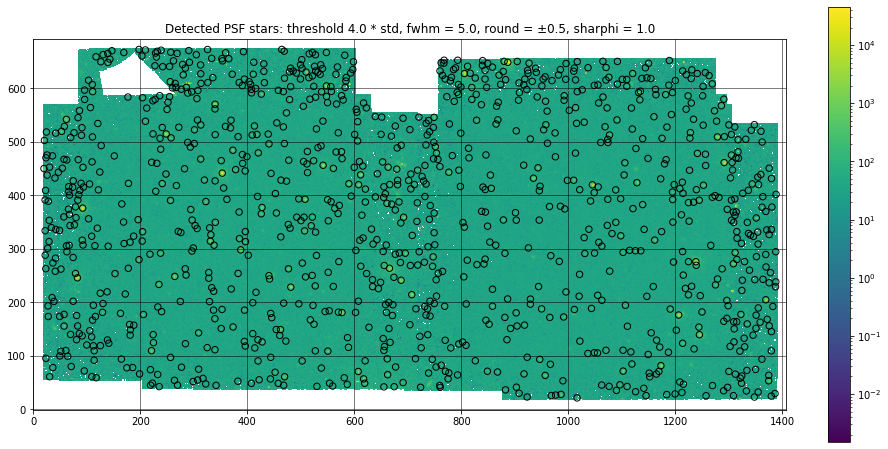

Number of stars detected = 1115



Number of PSF stars found and analysed = 1719

 id        x_0         ...    apparent_mag      apparent_mag_err  
--- ------------------ ... ------------------ --------------------
  1 1016.3232602275673 ... 14.480632267406717  0.04393634941775449
  2  922.9319407715149 ...                nan                  nan
 12  907.9100221408738 ...                nan                  nan
 25  902.9094237303437 ... 17.693227201955573  0.08717941269263811
  3 1347.7232563111438 ... 16.888227558592853 0.041901483106659164
 16 1354.7526415262232 ... 19.174492647054237  0.28325768649208544
 18 1332.7972076044207 ...  19.02547588718378  0.24517733077696025
 50  1323.650870520313 ... 19.629652313467133  0.44720558560050677
 62 1321.2609477560507 ... 18.934420701247586  0.22605714118580034
 71 1324.1050236974966 ...  16.93373740904617 0.042971923597630135
...                ... ...                ...                  ...
228  268.5779065314694 ...                nan                  nan
231  513.335142

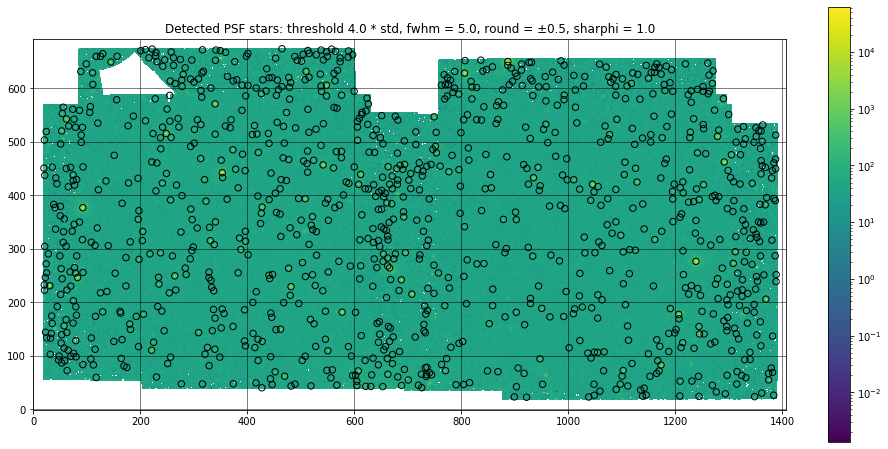

Number of stars detected = 1081



Number of PSF stars found and analysed = 1589

 id        x_0         ...    apparent_mag      apparent_mag_err  
--- ------------------ ... ------------------ --------------------
  1  921.8236542458384 ...                nan                  nan
  2  899.0344810249503 ...                nan                  nan
 20   903.017734443153 ... 17.681211635994604  0.09242162180105257
  3 1038.0352591016676 ... 19.047117279824764  0.27109183141975185
  9 1048.3954291778673 ...  19.07625667078084  0.28554909551366975
 14 1059.0234999152499 ...                nan                  nan
 37 1047.8488021616922 ... 18.373416934197408  0.15029248484058372
  4 1244.1279765890847 ...                nan                  nan
  5 1348.1453556578072 ...  16.81771776120884 0.041342533879173936
 12 1361.3459949446576 ...  19.54146002842392    0.399908776176072
...                ... ...                ...                  ...
191 229.20265261013296 ...  26.43897928323482   222.29958002530728
190  504.083785

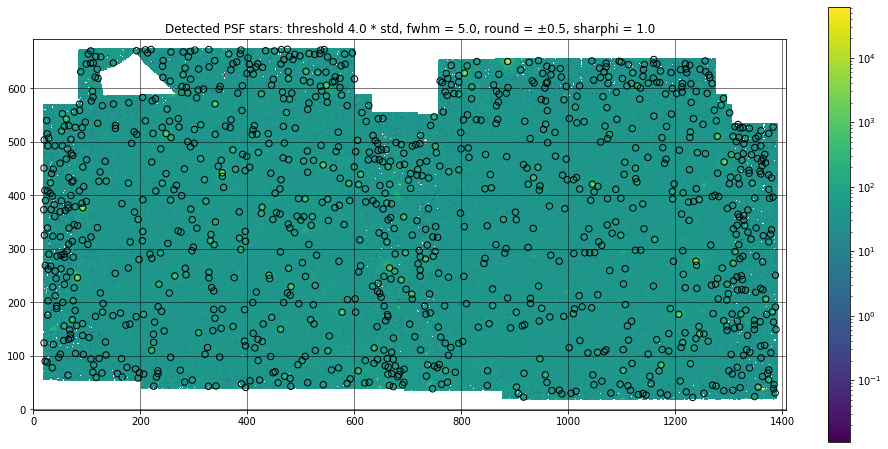

Number of stars detected = 1116



Number of PSF stars found and analysed = 1709

 id        x_0                y_0            apparent_mag      apparent_mag_err 
--- ------------------ ------------------ ------------------ -------------------
  1  916.3671085068697 23.090206583803027  20.64226228495292  1.3910621205882907
  9  906.3829167594121 29.774327717321054                nan                 nan
 26  903.0270558806393 41.971359478615675 17.678101040110036   0.094177648074138
  2 1232.3510003881336 22.539240664164172  20.22857261988248  0.9448138985847897
 16 1220.2953903098546  32.91136395684072                nan                 nan
  3 1348.0835274729357 24.070731595869557 17.049253513582343  11.167031409669848
 27  1354.629605569884  41.70997057693891 12.002647003450736 0.11017874841731598
  4 1145.2521467691158 26.879143574423267  17.23818238111976 0.05636316716968517
  8  1130.792802872263 27.934884340793673 21.374734218471225  2.2943568475293543
 10 1139.5491111361655 29.843499843318746                nan  

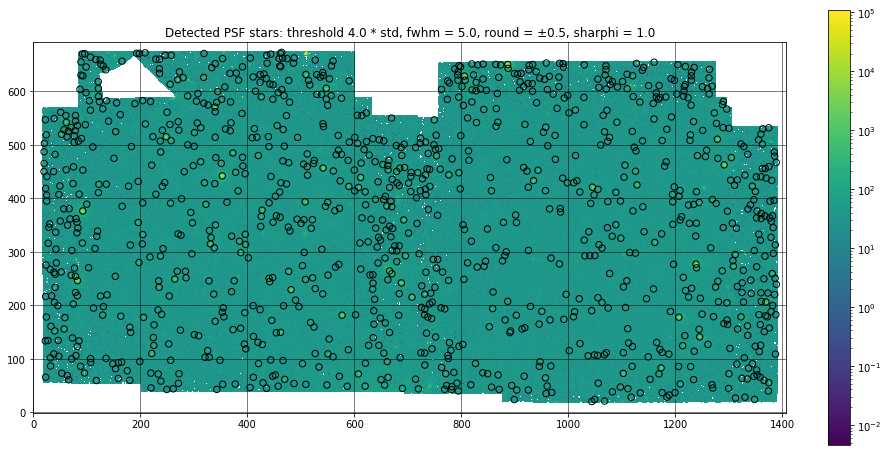

Number of stars detected = 1104



Number of PSF stars found and analysed = 1678

 id        x_0                y_0            apparent_mag      apparent_mag_err 
--- ------------------ ------------------ ------------------ -------------------
  1 1043.8463571218788   20.4013894764093 20.124657122358666   1.020450326994719
  2 1067.7073167139772 21.338192932759643 20.763356619314393   1.873481563731256
  4 1049.3178337786512  24.13061526677662 18.498332127167696 0.24368486130125938
  3  898.9448219414086  24.06253591347273                nan                 nan
 19  903.6155112954518  41.92467675965887  17.49393756496714 0.06289319476596349
 43  894.1214370549093  50.46536586036005 17.739820506374286 0.07092957900850456
  5 1347.9959064527486  24.32031241008557 17.023821899329278 0.04923374280268713
  7 1312.3912621343884 27.001005664934972 18.839939666289943  0.2505855749738204
  9  1330.109813938216 28.551846729879042 19.192352117786577  0.3188328921347679
  6 1117.4506779702926  28.60305971367196                nan  

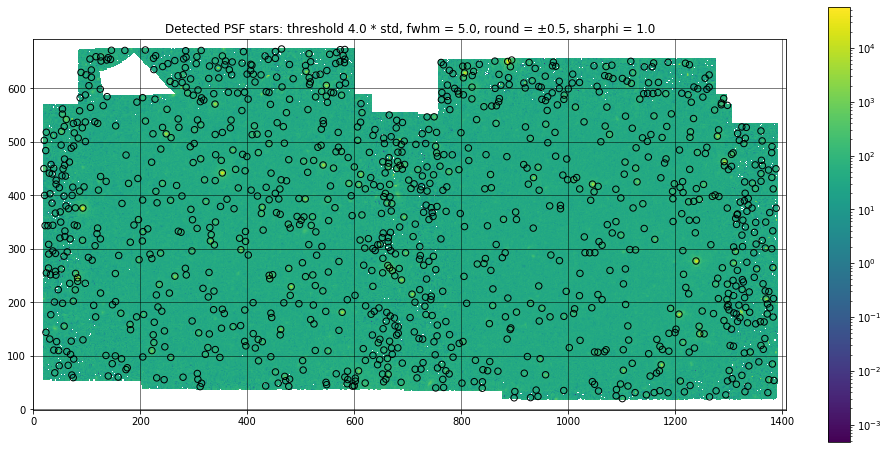

Number of stars detected = 1134



Number of PSF stars found and analysed = 1696

 id        x_0         ...    apparent_mag      apparent_mag_err  
--- ------------------ ... ------------------ --------------------
  1   929.284177362238 ...                nan                  nan
  5  943.2192870761496 ...  20.10507206709249   0.8194892886778222
 18  939.8241539647562 ... 18.686778935608128  0.22507051493508978
  2 1100.8614294237022 ... 15.977189719022217  0.05378250691022277
  6  1089.291788100109 ... 22.103796853864342   13.766545883649641
  9 1124.7627776521701 ... 14.797005909204675 0.029170147181245783
 21 1089.9508074513046 ... 17.574413066181776  0.20938709494594732
 30  1111.344742782834 ...  17.79556494577621  0.27353437355340837
 37 1097.5075676402234 ...  16.99598366692138   0.1273628152901837
  3  898.6323458428187 ... 20.552936998491187   1.4548684201220679
...                ... ...                ...                  ...
225  107.4503561188135 ... 21.711060694270948    3.967003779203492
216 456.4188803

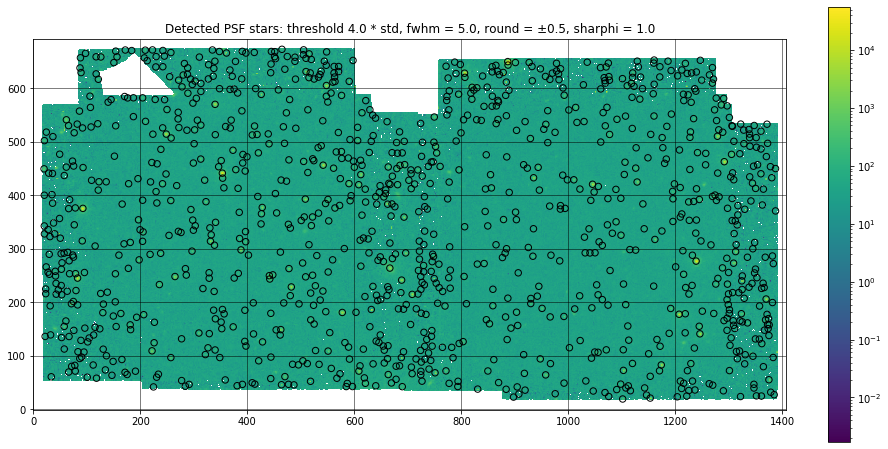

Number of stars detected = 1131



Number of PSF stars found and analysed = 1674

 id        x_0         ...    apparent_mag      apparent_mag_err  
--- ------------------ ... ------------------ --------------------
  1  1101.505766197628 ... 16.206255396010796  0.06918739281785542
  2  1153.005070064683 ... 13.872249230686482 0.029351951499809407
 10 1146.1150322488365 ... 17.456242557017966   0.4759705284168659
 27 1142.5859147477636 ... 17.511634910603146   0.4847772305676522
  3  897.5054718843292 ... 20.804659651836104   1.3139396141029005
 12  907.4890769472356 ...                nan                  nan
 20  919.0982027781839 ... 19.275284829733963  0.31844157067118783
 30  904.3733576708047 ... 17.861567492275206  0.09056770631394728
  4  1075.472082867314 ...                nan                  nan
 14 1068.4885167477146 ... 20.277400445202527    0.674295356720841
...                ... ...                ...                  ...
195 347.76870602130896 ... 20.698153927497444   1.1958573107725123
196  390.514241

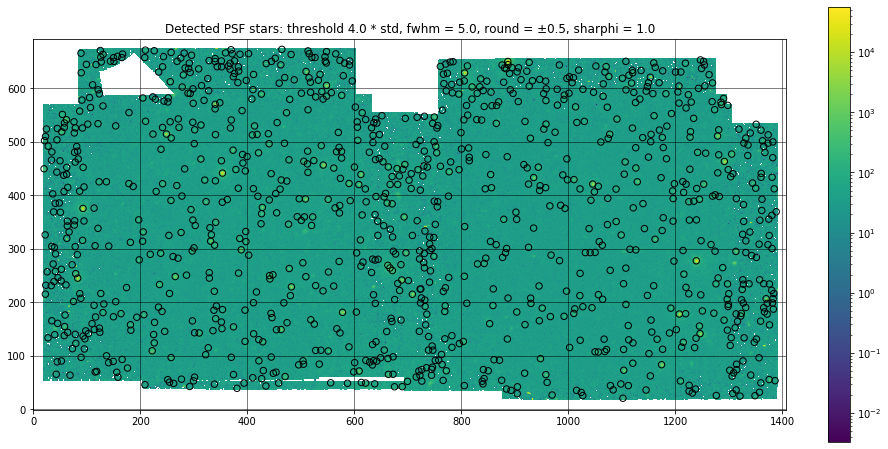

Number of stars detected = 1094



Number of PSF stars found and analysed = 1634

 id        x_0         ...    apparent_mag      apparent_mag_err  
--- ------------------ ... ------------------ --------------------
  1 1102.0242293192464 ...  16.07425305590603 0.047360198211465455
  2  1320.819556695561 ...                nan                  nan
  8 1307.2780864079725 ... 18.733162966397483   0.2219309807669856
 17 1313.5770934522568 ...                nan                  nan
  3 1027.0165153880469 ... 20.600603223139178   0.9975348225055977
  9 1024.0109642435534 ... 19.460585808527423  0.35064584607726235
 15 1015.4143661567923 ... 18.702217159071537   0.1758221329403327
  4 1276.5545634823804 ...  18.91475307508803  0.26697245430984423
  5 1348.8529031480198 ... 17.376247953355154   0.1045952850103616
 11 1357.1406838452199 ... 19.461031995728327   0.6985744662108097
...                ... ...                ...                  ...
196 195.80677414998806 ... 23.655655758458945   25.520300600100743
193 132.6358667

In [28]:
## PSF PHOTOMETRY ON ALL EPOCHS ##

## PARAMETERS ##

sigma_psf = 4.
fwhm = 5.
r_ap = 6.
r_in = 6.
r_out = 14.
roundlo = -0.5
roundhi = 0.5
sharphi = 1.0
do_plot = False

## EPOCH LOOP COUNTER ##

epoch = 0

## PSF PHOTOMETRY LOOP ##
for file in glob.glob(base_dir+'PAL5__e[0-9]_'+channel+'.fits', recursive = True) + glob.glob(base_dir+'PAL5__e[0-9][0-9]_'+channel+'.fits', recursive = True):
    epoch += 1
    print('EPOCH NUMBER = {0}\n'.format(epoch))
    ## OPENING FITS FILE AND EXTRACTING DATA ##
    with fits.open(file) as header_list:
        header = header_list[0].header
        fluxconv = header['FLUXCONV']
        exptime = header['EXPTIME']
        time = Time(header['DATE_OBS'])
        counts = exptime / fluxconv
        
        image_data = fits.getdata(file, ext = 0)
        data = image_data * counts
        
        print('FITS file information:\nFILE = {0}\nDATE = {1}\nFLUXCONV = {2}\nEXPTIME = {3}\n\n'.format(file, time, fluxconv, exptime))

    ## EXTRACTING LOC-DEPENDENT CORRECTIONS ##
    corr_file = general_dir+'PAL5__e'+str(epoch)+'/PAL5__e'+str(epoch)+'_correction_'+channel+'.fits'
    with fits.open(corr_file) as hdu_list:
        corr_data = hdu_list[0].data
    
    ## SOURCE DETECTION ON IMAGE ## 
    psf_daofind = DAOStarFinder(fwhm = fwhm, threshold = sigma_psf * std, roundlo = roundlo, roundhi = roundhi)
    psf_sources = psf_daofind(data)

    psf_positions = np.transpose((psf_sources['xcentroid'], psf_sources['ycentroid']))
    psf_apertures = CircularAperture(psf_positions, r = 6.)

    plt.imshow(data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
    psf_apertures.plot(color = 'black', lw = 1.)
    plt.colorbar(fraction = 0.05)
    plt.title('Detected PSF stars: threshold {0} * std, fwhm = {1}, round = ±{2}, sharphi = {3}'
              .format(sigma_psf, fwhm, roundhi, sharphi))
    plt.grid(b = True, which = 'major', lw = .5, color = 'black')
    plt.grid(b = True, which = 'minor', lw = .5, color = 'black')
    plt.gcf().set_size_inches(15, 8)
    plt.show()
    plt.close()
    print('Number of stars detected = {0}\n'.format(len(psf_sources)))
    
    ## GROUP ##

    psf_sources['xcentroid'].name = 'x_0'
    psf_sources['ycentroid'].name = 'y_0'

    daogroup = DAOGroup(crit_separation = sigma_psf * fwhm)
    bkg_estimator = MMMBackground()
    fitter = LevMarLSQFitter()

    data_psf = np.nan_to_num(data, nan = 1**-7)

    ## FIXED CENTROIDS ##

    epsf.x_0.fixed = True
    epsf.y_0.fixed = True
    pos = Table(names = ['x_0', 'y_0'], data = [psf_sources['x_0'], psf_sources['y_0']])
    
    ## PERFORMING PSF PHOTOMETRY ##

    PSF_photometry = IterativelySubtractedPSFPhotometry(finder = psf_daofind,
                                                        group_maker = daogroup,
                                                        bkg_estimator = bkg_estimator,
                                                        psf_model = epsf,
                                                        fitter = fitter,
                                                        niters = 3,
                                                        aperture_radius = 6.,
                                                        fitshape = (11, 11))

    result_phot = PSF_photometry(image = data_psf, init_guesses = pos)
    residual_image = PSF_photometry.get_residual_image()
    
    #hdu = fits.PrimaryHDU(residual_image)
    #hdul = fits.HDUList([hdu])
    #hdul.writeto('residual_image_08_fixed_centroids.fits')
    print('Number of PSF stars found and analysed = {0}\n'.format(len(result_phot)))
    
    if do_plot == True:
        ## VISUALISE PSF IMAGE AND RESIDUALS ##
        plt.subplot(1, 2, 1)
        plt.imshow(data_psf, cmap = 'viridis', norm = LogNorm(), interpolation = 'nearest', origin = 'lower', vmin = 0.000001, vmax = 10**6)
        plt.title('input data')
        plt.colorbar(orientation = 'horizontal')

        plt.subplot(1, 2, 2)
        plt.imshow(residual_image, cmap = 'viridis', norm = LogNorm(), interpolation = 'nearest', origin = 'lower', vmin = 0.000001, vmax = 10**6)
        plt.title('residual image')
        plt.colorbar(orientation = 'horizontal')
        plt.gcf().set_size_inches(20, 14)
        plt.show()
        plt.close()
    elif do_plot == False:
        pass
    
    phot = result_phot   # REDEFINE PHOTOMETRY TABLE FOR EASE
    
    ## PHOTOMETRY: UNCERTAINTIES ##
    
    PSF_err = phot['flux_unc']
    PSF_flux = phot['flux_fit'] 
    
    ## APPARENT MAGNITUDES ##
    
    phot['apparent_mag'] = float('NaN')
    for i in range(0, len(phot)):
        # APPLY ARRAY-LOC DEP CORRECTION
        loc_corr = corr_data[int(phot['y_fit'][i])][int(phot['x_fit'][i])]
        if phot['flux_fit'][i] >= 0:
            phot['apparent_mag'][i] = zmag - 2.5 * math.log10(phot['flux_fit'][i] * aper_corr * loc_corr / counts)
    
    ## APPARENT MAGNITUDE: UNCERTAINTIES ##
    
    phot['apparent_mag_err'] = float('Nan')
    for i in range(0, len(phot)):
        if phot['flux_fit'][i] >= 0:
            phot['apparent_mag_err'][i] = pow(zmag_err**2 + (2.5*(pow((PSF_err[i] / PSF_flux[i])**2 + (ap_err / aper_corr)**2, 0.5) / (np.log(10)))**2), 0.5)
    
    ## EXPORT PHOTOMETRY FILE AND PRINT TO SCREEN ##
    phot['id', 'x_0', 'y_0', 'apparent_mag', 'apparent_mag_err'].write(
        r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\output_files\PAL5_PSFphot_01_epoch{0}_channel{1}.txt'.format(epoch, channel), format = 'csv', overwrite = False)
    
    print(phot['id', 'x_0', 'y_0', 'apparent_mag', 'apparent_mag_err'])
    print('\n\n')

In [18]:
## MATCH STARS BETWEEN EPOCHS ##

file_1 = r'C:/Users/lukeb/Documents/MPhys_Project_RRLs/Luke_RRLs_project/output_files/PAL5_PSFphot_01_epoch1_channel3p6um.txt'

## EPOCH LOOP COUNTER ##

epoch = 1

time_list = [0]

for file_2 in glob.glob(r'C:/Users/lukeb/Documents/MPhys_Project_RRLs/Luke_RRLs_project/output_files/PAL5_PSFphot_01_epoch[2-9]_channel'+channel+'.txt', recursive = True) + glob.glob(r'C:/Users/lukeb/Documents/MPhys_Project_RRLs/Luke_RRLs_project/output_files/PAL5_PSFphot_01_epoch[0-9][0-9]_channel'+channel+'.txt', recursive = True):
    
    epoch += 1
    print('EPOCH NUMBER = {0}\n'.format(epoch))
    
    image_1 = 'PAL5_data/PAL5__e1/PAL5__e1_3p6um.fits'
    image_2 = str('PAL5_data/PAL5__e{0}/PAL5__e{0}_3p6um.fits'.format(epoch))
    
    with fits.open(image_1) as hdr_1_list:
        hdr_1 = hdr_1_list[0].header
        time1 = Time(hdr_1['DATE_OBS'])
        
    with fits.open(image_2) as hdr_2_list:
        hdr_2 = hdr_2_list[0].header
        time2 = Time(hdr_2['DATE_OBS'])
    
    delta_time = time2 - time1
    time_list.append(delta_time.sec)
    
    f1 = ascii.read(file_1, delimiter = ',')
    f2 = ascii.read(file_2, delimiter = ',')
    
    x_1 = f1['x_0']
    y_1 = f1['y_0']
    x_2 = f2['x_0']
    y_2 = f2['y_0']
    
    w1 = wcs.WCS(hdr_1)
    w2 = wcs.WCS(hdr_2)

    coord_1 = np.transpose((x_1, y_1))
    coord_2 = np.transpose((x_2, y_2))
    world_1 = w1.wcs_pix2world(coord_1, 0)
    world_2 = w2.wcs_pix2world(coord_2, 0)

    ra_1, dec_1 = world_1[:, 0], world_1[:, 1]
    ra_2, dec_2 = world_2[:, 0], world_2[:, 1]

    c_1 = SkyCoord(ra_1, dec_1, frame = 'icrs', unit = 'deg')
    c_2 = SkyCoord(ra_2, dec_2, frame = 'icrs', unit = 'deg')

    idx, d2d, d3d = c_2.match_to_catalog_sky(c_1)

    # APPEND RIGHT ASCENSION AND DECLINATION TO EXISTING FILES
    f1['ra'] = ra_1
    f1['dec'] = dec_1
    f2['ra'] = ra_2
    f2['dec'] = dec_2
    
    f1['ra_hms'] = str('null')
    f1['dec_dms'] = str('null')
    f2['ra_hms'] = str('null')
    f2['dec_dms'] = str('null')
    
    # FOLLOWING TUTORIAL, ENSURE MATCHES ARE SIGNIFICANT
    radius = 0.0001
    selection = (d2d > radius*u.deg)
    match_index = idx
    match_index[selection] = -99.
    matches = (match_index >= 0)

    mag_1 = f1['apparent_mag'][match_index][matches]
    mag_2 = f2['apparent_mag'][matches]
    mag_1_err = f1['apparent_mag_err'][match_index][matches]
    mag_2_err = f2['apparent_mag_err'][matches]
    delta_mag = mag_1 - mag_2
    print('Number of matched stars between epoch 1 and {0} = {1}\n'.format(epoch, len(delta_mag)))
    
    # CONSTRUCT TABLE OF MATCHED STARS
    matched_tbl_1 = Table()
    matched_tbl_2 = Table()
    ra_1m, dec_1m = f1['ra'][match_index][matches], f1['dec'][match_index][matches]
    ra_2m, dec_2m = f2['ra'][matches], f2['dec'][matches]
    matched_tbl_1['ra1'], matched_tbl_1['dec1'] = ra_1m, dec_1m
    matched_tbl_2['ra2'], matched_tbl_2['dec2'] = ra_2m, dec_2m
    matched_tbl_1['mag_1'] = mag_1
    matched_tbl_2['mag_2'] = mag_2
    matched_tbl_1['mag_1_err'] = mag_1_err
    matched_tbl_2['mag_2_err'] = mag_2_err
    
    # INITIALIZE COLUMNS FOR CONVERTING RIGHT ASCENSION AND DECLINATION FOR COMPARISON TO STAR CATALOGUE
    # RIGHT ASCENSION TO BE CONVERTED INTO HOURS:MINUTES:SECONDS
    # DECLINATION TO BE CONVERTED INTO DEGRESS:MINUTES:SECONDS
    matched_tbl_1['ra_hms'] = str('null')
    matched_tbl_1['dec_dms'] = str('null')
    matched_tbl_2['ra_hms'] = str('null')
    matched_tbl_2['dec_dms'] = str('null')
    
    # CONVERTING STRING COLUMNS IN TABLES INTO OBJECT
    for col in matched_tbl_1.itercols():
        if col.dtype.kind in 'SU':
            matched_tbl_1.replace_column(col.name, col.astype('object'))
    for col in matched_tbl_2.itercols():
        if col.dtype.kind in 'SU':
            matched_tbl_2.replace_column(col.name, col.astype('object'))
    
    # PERFORMING CONVERSIONS
    for i in range(len(matched_tbl_1)):
        ra_deg = Angle(matched_tbl_1['ra1'][i], u.deg)
        matched_tbl_1['ra_hms'][i] = ra_deg.to_string(unit = u.hour, sep=':')
    for i in range(len(matched_tbl_1)):
        dec_deg = Angle(matched_tbl_1['dec1'][i], u.deg)
        matched_tbl_1['dec_dms'][i] = dec_deg.to_string(unit = u.degree, sep=':')
    for i in range(len(matched_tbl_2)):
        ra_deg = Angle(matched_tbl_2['ra2'][i], u.deg)
        matched_tbl_2['ra_hms'][i] = ra_deg.to_string(unit = u.hour, sep=':')
    for i in range(len(matched_tbl_2)):
        dec_deg = Angle(matched_tbl_2['dec2'][i], u.deg)
        matched_tbl_2['dec_dms'][i] = dec_deg.to_string(unit = u.degree, sep=':')
    
    # EXPORT CONVERTED TABLES
    matched_tbl_1['ra_hms', 'dec_dms', 'mag_1', 'mag_1_err'].write(r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\output_files\PAL5_matched_stars_01_epoch1_{0}.txt'.format(channel), format = 'csv', overwrite = True)
    matched_tbl_2['ra_hms', 'dec_dms', 'mag_2', 'mag_2_err'].write(r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\output_files\PAL5_matched_stars_01_epoch{0}_{1}.txt'.format(epoch, channel), format = 'csv', overwrite = True)

EPOCH NUMBER = 2

Number of matched stars between epoch 1 and 2 = 527

EPOCH NUMBER = 3

Number of matched stars between epoch 1 and 3 = 545

EPOCH NUMBER = 4

Number of matched stars between epoch 1 and 4 = 503

EPOCH NUMBER = 5

Number of matched stars between epoch 1 and 5 = 482

EPOCH NUMBER = 6

Number of matched stars between epoch 1 and 6 = 486

EPOCH NUMBER = 7

Number of matched stars between epoch 1 and 7 = 494

EPOCH NUMBER = 8

Number of matched stars between epoch 1 and 8 = 490

EPOCH NUMBER = 9

Number of matched stars between epoch 1 and 9 = 481

EPOCH NUMBER = 10

Number of matched stars between epoch 1 and 10 = 485

EPOCH NUMBER = 11

Number of matched stars between epoch 1 and 11 = 488

EPOCH NUMBER = 12

Number of matched stars between epoch 1 and 12 = 499



In [1]:
magnitudes = [16.5776,
              16.4341,
              16.4177,
              16.4532,
              16.4204,
              16.4732,
              16.4265,
              16.4563,
              16.4105,
              16.4760,
              16.4761,
              16.3585]

magnitudes_err = [0.03218,
                  0.03232,
                  0.03095,
                  0.03190,
                  0.02898,
                  0.03406,
                  0.03141,
                  0.03262,
                  0.03316,
                  0.03251,
                  0.03097,
                  0.03050]



#    elinewidth=2,
#    markeredgewidth=2
    
plt.plot(time_list, magnitudes, color = 'kx', linestyle='None', markersize = 5)
plt.errorbar(x = time_list, y = magnitudes, xerr = None, yerr = magnitudes_err, fmt = 'o', capsize = 5)
plt.title('RRL ID1')
plt.xlabel('time [seconds]')
plt.ylabel('apparent magnitude')
plt.grid()
plt.gca().invert_yaxis()
plt.gcf().set_size_inches(10, 5)
plt.show()
plt.close()

NameError: name 'plt' is not defined